<a href="https://colab.research.google.com/gist/jteichma/4d9c0079dbf4e9c3cdff3fd1befabd23/deep_hedging_bs_conditionalrewards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Stock Prices under the Heston Model

## Heston Model

### [Formula](https://en.wikipedia.org/wiki/Heston_model)

The price of the asset $S_t$ is determined by a stochastic process:

<center> $dS_{t}=\mu S_{t}\,dt+{\sqrt  {\nu_{t}}}S_{t}\,dW_{t}^{S}$ </center>

The instantaneous variance $\nu_t$ is a CIR process:

<center> $d\nu_{t}=\kappa (\theta -\nu_{t})\,dt+\xi {\sqrt  {\nu_{t}}}\,dW_{t}^{{\nu }}$ </center>

where $W_{t}^{S},W_{t}^{\nu }$ are Wiener processes (continuous random walks) with correlation $\rho$.

The parameters in the above equations represent the following:
- $\mu$ is the rate of return of the asset.
- $\theta$ is the long variance, or long run average price variance; as $t$ tends to infinity, the expected value of $\nu_t$ tends to $\theta$.
- $\kappa$ is the rate at which $\nu_t$ reverts to $\theta$.
- $\xi$ is the volatility of the volatility, or 'vol of vol', and determines the variance of $\nu_t$.

If $2\kappa \theta >\xi ^{2}$ (Feller condition), then the process $\nu_t$ is strictly positive.


### Discretization
Forward Euler for Heston model

<center> $\nu_{t} = \nu_{t-1} + \kappa (\theta -\nu_{t-1})\frac{T}{N} + \xi{\sqrt{|\nu_{t-1}|}}\sqrt{\frac{T}{N}} Z_{t}^{\nu}$ </center>

<center> $\log(S_t)= \log(S_{t-1}) -\frac{\nu_{t}^2}{2} \frac{T}{N} + \nu_{t} \sqrt{\frac{T}{N}} Z_{t}^{S}$ </center>


### Implementation Decisions (to be made)
- Initialization - does it matter in our case?
- Parameter tuning - maybe it doesn't matter in our case either
- What to do when v < 0? abs, trunc? Do we apply it to all v's in the formula?

### Some References
- https://www.degruyter.com/document/doi/10.1515/math-2017-0058/html#:~:text=The%20main%20parameters%20of%20interest,increases%20the%20prices%20of%20options
- https://www.quantstart.com/articles/Heston-Stochastic-Volatility-Model-with-Euler-Discretisation-in-C/
- https://arxiv.org/pdf/1502.02963.pdf
- https://www.valpo.edu/mathematics-statistics/files/2015/07/Estimating-Option-Prices-with-Heston%E2%80%99s--Stochastic-Volatility-Model.pdf
- Heston code (Michele mentioned it in the last meeting): https://github.com/daleroberts/heston/blob/master/heston.r

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Dimensions
m = 1           # dimention of output
Ktrain = 10**5  # number of training models

N = 100         # time disrectization
T = 1           # maturity

## Parameters
corr = -0.3     # correlation between the two process
kappa = 0.9     # kappa: mean reversion rate
theta = 0.2     # theta: long-term volatility
xi = 0.2        # xi: volatility of volatility

## Initialization - could have other values
S0 = 1 * np.ones((Ktrain,m))
v0 = theta * np.ones((Ktrain,m))
S = [S0]
v = [v0]

## Simulation - generate volatility and stock price from day 0 to day N

v_curr = v0; S_curr = S0

for i in range(N):
    
    # Simulate standard normal random variables
    Z1_i = np.random.normal(0,1,(Ktrain,m))
    Z2_i = np.random.normal(0,1,(Ktrain,m))
    
    # Generate correlated Brownian motions
    WS_curr = np.sqrt(T/N)*Z1_i
    Wv_curr = np.sqrt(T/N)*(corr*Z1_i + np.sqrt(1-corr**2)*Z2_i)
    
    # Calculate volatility and stock price
    # Adjustment: np.abs(v_curr) for np.sqrt() in the last term
    v_new = v_curr + kappa*(theta-v_curr)*T/N + xi*np.sqrt(np.abs(v_curr))*Wv_curr
    S_new = np.exp(np.log(S_curr) - v_new**2/2*T/N + v_new*WS_curr)
    
    v_curr = v_new; S_curr = S_new
    
    # Append the results to the arrays of each day's value
    v += [v_new]; S += [S_new]
    

0.9736524915789709
0.19869749780746856


(array([3.0000e+00, 2.1000e+01, 1.5800e+02, 7.2600e+02, 2.3060e+03,
        5.8570e+03, 1.0759e+04, 1.5938e+04, 1.8680e+04, 1.7022e+04,
        1.2457e+04, 7.7250e+03, 4.3400e+03, 2.1740e+03, 1.0070e+03,
        4.7300e+02, 1.9100e+02, 8.7000e+01, 3.9000e+01, 2.0000e+01,
        1.1000e+01, 4.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([0.18497177, 0.27389178, 0.3628118 , 0.45173181, 0.54065182,
        0.62957184, 0.71849185, 0.80741187, 0.89633188, 0.98525189,
        1.07417191, 1.16309192, 1.25201193, 1.34093195, 1.42985196,
        1.51877198, 1.60769199, 1.696612  , 1.78553202, 1.87445203,
        1.96337205, 2.05229206, 2.14121207, 2.23013209, 2.3190521 ,
        2.40797211]),
 <BarContainer object of 25 artists>)

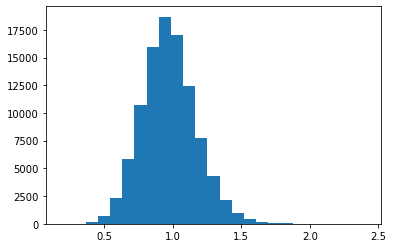

In [3]:
print(np.mean(S[N]))
print(np.std(S[N]))
plt.hist(S[N], bins = 25)

## Comparison - Constant Volatility

In [4]:
## Dimensions
m = 1           # dimention of output
Ktrain = 10**5  # number of training models

N = 100         # time disrectization
T = 1           # maturity

## Parameters
corr = -0.3     # correlation between the two process
kappa = 0.7     # kappa: mean reversion rate
theta = 0.2     # theta: long-term volatility
xi = 0.4        # xi: volatility of volatility


## Initialization - could have other values
S0 = 1 * np.ones((Ktrain,m))
v0 = theta * np.ones((Ktrain,m))
S = [S0]
v = [v0]

## Simulation
# generate volatility and stock price from day 0 to day N

v_curr = v0; S_curr = S0

for i in range(N):
    
    # Simulate standard normal random variables
    Z1_i = np.random.normal(0,1,(Ktrain,m))
    WS_curr = np.sqrt(T/N)*Z1_i
    S_new = np.exp(np.log(S_curr) - v0**2/2*T/N + v0*WS_curr)
    S_curr = S_new
    
    # Append the results to the arrays of each day's value
    S += [S_new]
    


0.9995654951401842
0.20132038091651966


(array([3.0000e+00, 4.8000e+01, 4.3700e+02, 2.0110e+03, 5.4670e+03,
        1.0009e+04, 1.4007e+04, 1.5682e+04, 1.4973e+04, 1.2335e+04,
        9.2590e+03, 6.4000e+03, 3.9330e+03, 2.4080e+03, 1.3430e+03,
        8.2200e+02, 4.3700e+02, 1.9900e+02, 1.2600e+02, 5.4000e+01,
        2.6000e+01, 1.7000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([0.3590734 , 0.43527257, 0.51147174, 0.58767091, 0.66387008,
        0.74006924, 0.81626841, 0.89246758, 0.96866675, 1.04486592,
        1.12106508, 1.19726425, 1.27346342, 1.34966259, 1.42586176,
        1.50206093, 1.57826009, 1.65445926, 1.73065843, 1.8068576 ,
        1.88305677, 1.95925593, 2.0354551 , 2.11165427, 2.18785344,
        2.26405261]),
 <BarContainer object of 25 artists>)

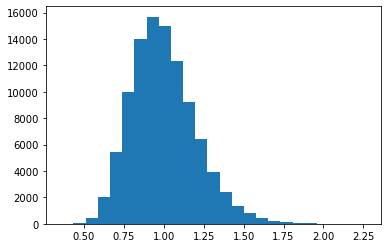

In [5]:
print(np.mean(S[N]))
print(np.std(S[N]))
plt.hist(S[N], bins = 25)

# The Greeks

### Main Reference

**Valuing European Option Using the Heston Model in QuantLib Python**

http://gouthamanbalaraman.com/blog/valuing-european-option-heston-model-quantLib.html

- kappa = 0.1   mean reversion strength 
- sigma = 0.1   vol of volatility 
- rho = -0.75   correlation between the asset price and its variance
- vol = 0.2     vol of the underlying stock (known to be 20%)
- v0 = vol^2 = 0.04   the spot variance 
- theta = v0    the mean reversion variance

### Some Other References

- QuantLib: setting up QuantLib-Python and pricing an option: https://www.quantopia.net/quantlib-setting-up-quantlib-python-and-pricing-an-option/
- Introducing QuantLib: Black-Scholes and the Greeks: https://mhittesdorf.wordpress.com/2013/07/29/introducing-quantlib-black-scholes-and-the-greeks/
- QuantLib, the Greeks and other useful option-related values: https://quantcorner.wordpress.com/2011/02/06/quantlib-the-greeks-and-other-useful-option-related-values/
- Heston Model: Formula, Assumptions, Limitations: https://blog.quantinsti.com/heston-model/

In [6]:
#!pip install QuantLib-Python

In [7]:
import QuantLib as ql

In [8]:
# option parameters
strike_price = 100.00
option_type = ql.Option.Call
maturity_date = ql.Date(31, 12, 2020)
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

# parameters for Heston
kappa = 0.1  # mean reversion strength
sigma = 0.1  # vol of vol
rho = -0.75  # corr between asset price and var
vol = 0.20   # historical vols for the stock
v0 = vol*vol # spot variance
theta = v0   # mean reversion variance

In [9]:
def heston_value(calculation_date, v0, spot_price):
    # set the evaluation date
    ql.Settings.instance().evaluationDate = calculation_date

    # construct the yield curve
    dividend_rate =  0
    risk_free_rate = 0
    flat_ts = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, risk_free_rate, day_count)
    )
    dividend_yield = ql.YieldTermStructureHandle(
        ql.FlatForward(calculation_date, dividend_rate, day_count)
    )

    # set the spot price
    spot_handle = ql.QuoteHandle(
        ql.SimpleQuote(spot_price)
    )
    
    # calculate option price
    heston_process = ql.HestonProcess(
    flat_ts, dividend_yield, spot_handle,
    v0, kappa, theta, sigma, rho
    )

    engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process),0.01, 1000)
    european_option.setPricingEngine(engine)
    h_price = european_option.NPV()
    
    return h_price

### Calculate the Greeks numerically
Use central finite difference

In [10]:
calculation_date = ql.Date(1, 10, 2020)
v0 = 0.04
spot_price = 100.00
price = heston_value(calculation_date, v0, spot_price)
print(price)


v0_delta = 0.001
spot_delta = 1

def calc_greeks(calculation_date, v0, spot_price):

    v0_plus  = v0 + v0_delta
    v0_minus = v0 - v0_delta
    spot_price_plus  = spot_price + spot_delta
    spot_price_minus = spot_price - spot_delta
    
    p_curr = heston_value(calculation_date, v0, spot_price)
    
    p_theta_plus  = heston_value(calculation_date, v0_plus,  spot_price)
    p_theta_minus = heston_value(calculation_date, v0_minus, spot_price)
    
    p_delta_plus  = heston_value(calculation_date, v0, spot_price_plus)
    p_delta_minus = heston_value(calculation_date, v0, spot_price_minus)
    
    delta = (p_delta_plus - p_delta_minus) / spot_delta * 2
    theta = (p_theta_plus - p_theta_minus) / v0_delta * 2
    
    return [delta, theta]

calc_greeks(calculation_date, v0, spot_price)

3.9643095229387697


[2.152885079854798, 196.48164768210563]